<div class="alert alert-info">
    
➡️ Make sure that you have read the **[rules for hand-in assignments](https://www.ida.liu.se/~TDDE16/exam.en.shtml#handins)** and the **[policy on cheating and plagiarism](https://www.ida.liu.se/~TDDE16/exam.en.shtml#cheating)** before starting with this lab.

➡️ Make sure you fill in any cells (and _only_ those cells) that say **`YOUR CODE HERE`** or **YOUR ANSWER HERE**, and do _not_ modify any of the other cells.

➡️ **Before you submit your lab, make sure everything runs as expected.** For this, _restart the kernel_ and _run all cells_ from top to bottom. In Jupyter Notebook version 7 or higher, you can do this via "Run$\rightarrow$Restart Kernel and Run All Cells..." in the menu (or the "⏩" button in the toolbar).

</div>

# L2: Text classification

Text classification is the task of sorting text documents into predefined classes. The concrete problem you will be working on in this lab is the classification of texts with respect to their political affiliation. The specific texts you are going to classify are speeches held in the [Riksdag](https://www.riksdagen.se/en/), the Swedish national legislature.

In [1]:
%matplotlib inline
#Use TfidfVectorizer when you want to give more importance to words that are frequent in a document but rare across the entire corpus. It's beneficial for information retrieval and content recommendation tasks where you need to find the most relevant documents.
from sklearn.feature_extraction.text import TfidfVectorizer
#Use CountVectorizer when you want to represent text data by counting the occurrences of words in documents. It's suitable for text classification and clustering.
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

## Data set

The raw data for this lab comes from [The Riksdag’s Open Data](https://data.riksdagen.se/in-english/). We have tokenized the speeches and put them into two compressed [JSON](https://en.wikipedia.org/wiki/JSON) files:

* `speeches-201718.json.bz2` (speeches from the 2017/2018 parliamentary session)
* `speeches-201819.json.bz2` (ditto, from the 2018/2019 session)

We start by loading these files into two separate data frames.

In [2]:
import pandas as pd
import bz2

with bz2.open('speeches-201718.json.bz2') as source:
    speeches_201718 = pd.read_json(source)

with bz2.open('speeches-201819.json.bz2') as source:
    speeches_201819 = pd.read_json(source)

When you inspect the two data frames, you can see that there are three labelled columns: `id` (the official speech ID), `words` (the space-separated words of the speech), and `party` (the party of the speaker, represented by its customary abbreviation).

In [3]:
speeches_201718.head()

,id,words,party
0,H5-002-004,eders majestäter eders kungliga högheter herr ...,S
1,H5-003-001,aktuell debatt om situationen för ensamkommand...,V
2,H5-003-002,herr talman och ledamöter jag vill börja med a...,S
3,H5-003-003,herr talman åhörare den här debatten handlar a...,M
4,H5-003-004,herr talman ansvar och rättssäkerhet är två or...,SD


Throughout the lab, we will be using the speeches from 2017/2018 as our training data, and the speeches from 2018/2019 as our test data.

In [4]:
training_data, test_data = speeches_201718, speeches_201819

For later reference, we store the sorted list of party abbreviations.

In [5]:
parties = sorted(training_data['party'].unique())
print(parties)

['C', 'KD', 'L', 'M', 'MP', 'S', 'SD', 'V']


## Problem 1: Visualization

Your first task is to get to know the data better by producing a simple visualization.

If you are not familiar with the Swedish political system and the parties represented in the Riksdag in particular, then we suggest that you have a look at the Wikipedia article about the [2018 Swedish general election](https://en.wikipedia.org/wiki/2018_Swedish_general_election).

For the lab, we ask you to compare the two data frames with respect to the distribution of the speeches over the different parties. **Write code to generate two bar plots that visualize this information**, one for the 2017/2018 speeches and one for the 2018/2019 speeches. Inspect the two plots, and compare them

* to each other
* to the results of the 2014 and the 2018 general elections

Summarize your observations in a short text in the cell below.

**Tip:** If you need help with creating bar plots, [Bar Plot using Pandas](https://dfrieds.com/data-visualizations/bar-plot-python-pandas) provides a useful tutorial.

<AxesSubplot:>

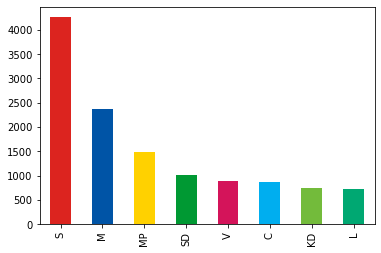

In [6]:
"""Produce a plot for the 2017/2018 speeches."""
swedish_party_colors = ['#DC241f','#0054A6','#FFD100','#009933','#D4145A','#00AEEF', '#73BB3B','#00A872']
training_data['party'].value_counts().plot(kind='bar',color=swedish_party_colors)


<AxesSubplot:>

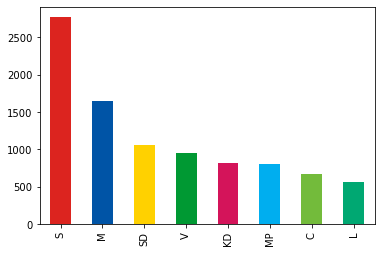

In [7]:
"""Produce a plot for the 2018/2019 speeches."""
test_data['party'].value_counts().plot(kind='bar',color=swedish_party_colors)


**Summarize your observations!**

When we look at the distribution of speeches across parties, comparing 2017-2018 to 2018-2019, a clear pattern emerges. Party S holds the majority, which is not surprising as it's the dominant party in parliament. It's followed by party M. However, what's intriguing is that party MP has shifted to one of the last three parties, while SD has moved to the top three. V and KD have also transitioned from being in the last three parties to the top tier. This shift may reflect the evolving public sentiment, as represented by the number of seats each party holds

## Problem 2: Naive Bayes classifier

You are now ready to train and evaluate a classifier. More specifically, we ask you to train a [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) classifier. You will have to

1. vectorize the speeches in the training data
2. instantiate and fit the Naive Bayes model
3. evaluate the model on the test data

The scikit-learn library provides a convenience class [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) that allows you to solve the first two tasks with very compact code. For the evaluation you can use the function [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html), which will report per-class precision, recall and F1, as well as overall accuracy.

**Write code to produce a Multinomial Naive Bayes classifier as described above and report its performance on the test data!**

In [8]:
#1. vectorize the speeches in the training data
#2. instantiate and fit the Naive Bayes model
pipeline = Pipeline([("vectorization ", CountVectorizer()),('Multinomial_Naive_Bayes', MultinomialNB()) ])
x_train = training_data['words']
y_train = training_data['party']
pipeline.fit(x_train,y_train)

Pipeline(steps=[('vectorization ', CountVectorizer()),
                ('Multinomial_Naive_Bayes', MultinomialNB())])

In [9]:
#3. evaluate the model on the test data
x_test = test_data['words']
y_test = test_data['party']

# Prediction
y_pred=pipeline.predict(x_test)

# Model evaluate
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           C       0.63      0.04      0.07       671
          KD       0.70      0.02      0.03       821
           L       0.92      0.02      0.04       560
           M       0.36      0.68      0.47      1644
          MP       0.36      0.25      0.29       809
           S       0.46      0.84      0.59      2773
          SD       0.57      0.12      0.20      1060
           V       0.59      0.15      0.24       950

    accuracy                           0.43      9288
   macro avg       0.57      0.26      0.24      9288
weighted avg       0.52      0.43      0.34      9288



Would you have expected the results that you got?

Analyzing the precision, it's interesting to note that our model achieved high precision for speeches related to the Liberals (L) and the Christian Democrats (KD). In contrast, the precision was lower for speeches related to the Moderate Party (M) and the Green Party (MP). This observation suggests that the language and overall political direction for the Liberals and the Christian Democrats remain relatively consistent. However, there may have been some changes in the mandates or focus for the Moderate Party and the Green Party.

## Problem 3: Baselines

Evaluation metrics such as accuracy should not be understood as absolute measures of performance, but should be used only to compare different classifiers. When other classifiers are not available, a simple baseline is a classifier that generates predictions by random sampling, respecting the training set&rsquo;s class distribution. This baseline is implemented by the class [DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html). 

**Write code to fit a random baseline on the training data and report its performance on the test data!**

In [10]:
#“stratified”: the predict_proba method randomly samples one-hot vectors from a multinomial distribution parametrized by the empirical class prior probabilities. The predict method returns the class label which got probability one in the one-hot vector of predict_proba. Each sampled row of both methods is therefore independent and identically distributed.
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(x_train, y_train)
y_pred = dummy_clf.predict(x_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           C       0.09      0.08      0.09       671
          KD       0.08      0.05      0.06       821
           L       0.07      0.07      0.07       560
           M       0.18      0.21      0.20      1644
          MP       0.09      0.11      0.10       809
           S       0.31      0.35      0.33      2773
          SD       0.13      0.10      0.11      1060
           V       0.11      0.07      0.09       950

    accuracy                           0.19      9288
   macro avg       0.13      0.13      0.13      9288
weighted avg       0.18      0.19      0.18      9288



An even dumber baseline is to predict, for every document, that class which appears most often in the training data. This baseline is also called the most frequent class baseline.

**Write code to fit the most-frequent-class baseline on the training data and report its performance on the test data!**

In [11]:
#“most_frequent”: the predict method always returns the most frequent class label in the observed y argument passed to fit. The predict_proba method returns the matching one-hot encoded vector.
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(x_train, y_train)
y_pred = dummy_clf.predict(x_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           C       0.00      0.00      0.00       671
          KD       0.00      0.00      0.00       821
           L       0.00      0.00      0.00       560
           M       0.00      0.00      0.00      1644
          MP       0.00      0.00      0.00       809
           S       0.30      1.00      0.46      2773
          SD       0.00      0.00      0.00      1060
           V       0.00      0.00      0.00       950

    accuracy                           0.30      9288
   macro avg       0.04      0.12      0.06      9288
weighted avg       0.09      0.30      0.14      9288



C:\Users\MOALI72\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MOALI72\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MOALI72\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Problem 4: Creating a balanced data set

As you saw in Problem&nbsp;1, the distribution of the speeches over the eight different parties (classes) is imbalanced. One technique used to alleviate this is **undersampling**, in which one randomly removes samples from over-represented classes until all classes are represented with the same number of samples.

Implement undersampling to create a balanced subset of the training data. Rerun the evaluation from Problem&nbsp;2 on the balanced data and compare the results. Summarise your results in a short text.

**Hint:** Your balanced subset should consist of 5,752 speeches.

**Write code to implement undersampling with the classifier from Problem 2 and report its performance on the test data!**

In [12]:
n_samples = training_data['party'].value_counts().min()
# For this we use RandomUnderSampler is a fast and easy way to balance the data by randomly selecting a subset of data for the targeted classes
# we specify the number of sample per class by the min number in our data set which is equal to 719.
# Ref : https://imbalanced-learn.org/stable/under_sampling.html#controlled-under-sampling
res = RandomUnderSampler(sampling_strategy={'C': n_samples, 'KD': n_samples, 'L': n_samples, 'M': n_samples,'MP': n_samples, 'S': n_samples, 'SD': n_samples,'V': n_samples})
x_train = training_data['words']
y_train = training_data['party']
x_rs,y_rs=res.fit_resample(x_train.values.reshape(-1,1), y_train)
len(x_rs)

5752

In [13]:
# Reshaping my arrays to fit in a data frame
y_resampled=y_rs.values.reshape(len(y_rs),1)
x_resampled=x_rs.reshape(len(x_rs),1)
# Fit the new samples in one pd df
df_resampled = pd.DataFrame(np.concatenate(( x_resampled,y_resampled), axis=1), columns=['words', 'party'])
#Getting the x and y resampled to be fitted and Rerun the evaluation from Problem 2 on the balanced data
x_train_resampled = df_resampled['words']
y_train_resampled = df_resampled['party']
#Using the pipeline fitted from problem 2
pipeline.fit(x_train_resampled,y_train_resampled)
# Prediction
y_pred=pipeline.predict(x_test)
# Model evaluate
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           C       0.26      0.44      0.33       671
          KD       0.29      0.38      0.33       821
           L       0.27      0.44      0.33       560
           M       0.43      0.50      0.46      1644
          MP       0.35      0.38      0.37       809
           S       0.82      0.29      0.43      2773
          SD       0.42      0.43      0.42      1060
           V       0.40      0.54      0.46       950

    accuracy                           0.41      9288
   macro avg       0.40      0.43      0.39      9288
weighted avg       0.50      0.41      0.41      9288



**Provide a brief summary of the results.**

YOUR ANSWER HERE
The results are intriguing. We notice that the precision for most of the political parties is quite low. However, the Social Democrats (S) stand out with a remarkable performance. It's worth noting that the dataset is heavily dominated by the Social Democrat party (S) in terms of the number of data points. Nevertheless, when we applied undersampling, we aimed to equalize the representation among the different parties. Therefore, we expected a more balanced precision across all parties.

## Problem 5: Confusion matrix

A **confusion matrix** is a specific table that is useful when analysing the performance of a classifier. In this table, both the rows and the columns correspond to classes, and each cell $(i, j)$ states how many times a sample with gold-standard class $i$ was predicted as belonging to class $j$.

In scitkit-learn, the confusion matrix of a classifier is computed by the function [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html). To generate a visual representation, you can use [`ConfusionMatrixDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html).

Your task is to use the confusion matrix in order to find, for each given party $p$ in the Riksdag, that other party $p'$ which the classifier that you trained in Problem&nbsp;4 most often confuses with $p$ when it predicts the party of a speaker.

**Write code to display/plot the confusion matrix for the classifier from Problem 4 as evaluated on the test data!**

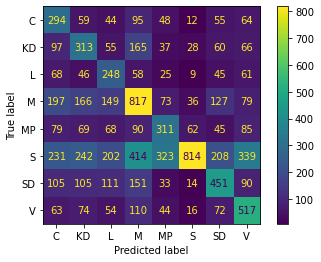

In [14]:
# Staring by setting up my lables
lables = ['C','KD','L','M','MP','S','SD','V']
# Setting the Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels= lables)
#MAtrix Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lables)
disp.plot()

**Write code that, for each party $p$, print the party most often confused with $p$ by the classifier from Problem 4!**

In [15]:
# Finding the the most confused party
for i in range(len(lables)):
    cm_new=cm[i,:]
    index_to_exclude=i
    labels_excluded = [index for i, index in enumerate(cm_new) if i != index_to_exclude]
    print('Party: ',lables[i],'is confused with party: ',lables[int(np.where(cm_new == max(labels_excluded))[0])])


Party:  C is confused with party:  M
Party:  KD is confused with party:  M
Party:  L is confused with party:  C
Party:  M is confused with party:  C
Party:  MP is confused with party:  M
Party:  S is confused with party:  M
Party:  SD is confused with party:  M
Party:  V is confused with party:  M


Take a minute to reflect on whether your results make sense.

Based on the results presented, it appears that Party M (Moderate) exhibits a higher degree of confusion with speeches from various other parties. This observation may be attributed to the fact that language usage, alongside political viewpoints and addressing, plays a significant role. To some extent, this finding makes sense as it aligns with the party's primary ideology, which is center-right. The Moderate Party characterizes its ideology as a blend of liberalism and conservatism, corresponding to the concept of liberal conservatism [https://en.wikipedia.org/wiki/Moderate_Party#:~:text=The%20Moderate%20Party%20states%20that%20its%20ideology%20is%20a%20mix%20of%20liberalism%20and%20conservatism%2C%20and%20corresponds%20to%20what%20is%20called%20liberal%20conservatism.].

## Problem 6: Grid search

Until now, you have been using the vectorizer and the Naive Bayes classifier with their default hyperparameters. When working with real-world applications, you would want to find settings for the hyperparameters that maximize the performance for the task at hand.

Manually tweaking the hyperparameters of the various components of a vectorizer–classifier pipeline can be cumbersome. However, scikit-learn makes it possible to run an exhaustive search for the best hyperparameters over a grid of possible values. This method is known as **grid search**.

The hyperparameters of a pipeline should never be tuned on the final test set. Instead, one should either use a separate validation set, or run cross-validation over different folds. Here we will use cross-validation.

Implement a grid search with 5-fold cross-validation to find the optimal parameters in a grid defined by the following choices for the hyperparameters:

* In the vectorizer, try a set-of-words (binary) model in addition to the default bag-of-words model (two possible parameter values).
* Also in the vectorizer, try extracting bigrams in addition to unigrams (two possible parameter values).
* In the Naive Bayes classifier, try using additive smoothing with $\alpha \in \{1, 0{.}1\}$ (two possible parameter values).

Use the class [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) from the scikit-learn library.

**Write code to perform grid search, then print the results of your best model, along with the parameter values that yielded these results.**

In [16]:
# We define our pipeline fist
pipe = Pipeline([("CountVectorizer", CountVectorizer()),('Multinomial_Naive_Bayes', MultinomialNB()) ])
num_flods = 5
param_grid = {
    'CountVectorizer__binary': [True, False],
    'CountVectorizer__ngram_range': [(1, 1), (1, 2)],
    'Multinomial_Naive_Bayes__alpha': [1,0.1]
                            }
grid_serach = GridSearchCV(pipe, param_grid, cv=num_flods)
grid_serach.fit(training_data['words'],training_data['party'])
grid_serach.best_params_

{'CountVectorizer__binary': False,
 'CountVectorizer__ngram_range': (1, 1),
 'Multinomial_Naive_Bayes__alpha': 0.1}

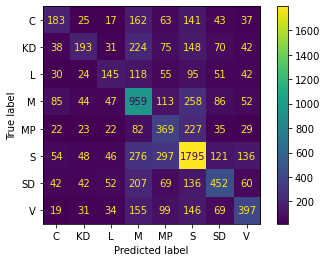

In [17]:
# Confusion matrix
ypred_best= grid_serach.best_estimator_.predict(test_data['words'])
lables = ['C','KD','L','M','MP','S','SD','V']
cm = confusion_matrix(y_test, ypred_best, labels= lables)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lables)
disp.plot()

In [18]:
print(classification_report(y_test,ypred_best))

              precision    recall  f1-score   support

           C       0.39      0.27      0.32       671
          KD       0.45      0.24      0.31       821
           L       0.37      0.26      0.30       560
           M       0.44      0.58      0.50      1644
          MP       0.32      0.46      0.38       809
           S       0.61      0.65      0.63      2773
          SD       0.49      0.43      0.45      1060
           V       0.50      0.42      0.46       950

    accuracy                           0.48      9288
   macro avg       0.45      0.41      0.42      9288
weighted avg       0.48      0.48      0.48      9288



## Problem 7: Try to improve your results

Scikit-learn makes it easy to test different vectorizer–classifier pipelines – among other things, it includes different types of logistic regression classifiers, support vector machines, and decision trees. Browse the library to see which methods are supported.

**Build a pipeline that you find interesting, and use grid search to find optimal settings for the hyperparameters. Print the results of your best model.**

#### Logistic Regression

In [19]:
# YOUR CODE HERE
pipe = Pipeline([("CountVectorizer", CountVectorizer()),("LogisticRegression", LogisticRegression(multi_class="multinomial", max_iter=100))])
num_flods = 5
param_grid = {
    'CountVectorizer__binary': [True, False],
    'CountVectorizer__ngram_range': [(1, 1), (1, 2)],
    'LogisticRegression__C': [0.5,1.0]  }
grid_serach = GridSearchCV(pipe, param_grid,scoring="accuracy", cv=num_flods)
grid_serach.fit(training_data['words'],training_data['party'])
grid_serach.best_params_

C:\Users\MOALI72\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\MOALI72\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

{'CountVectorizer__binary': False,
 'CountVectorizer__ngram_range': (1, 2),
 'LogisticRegression__C': 0.5}

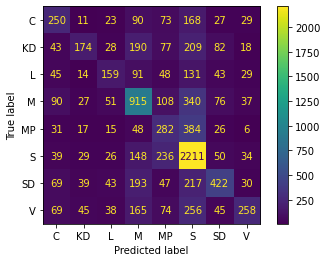

In [20]:
ypred_best= grid_serach.best_estimator_.predict(test_data['words'])
lables = ['C','KD','L','M','MP','S','SD','V']
cm = confusion_matrix(y_test, ypred_best, labels= lables)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lables)
disp.plot()

In [21]:
print(classification_report(y_test,ypred_best))

              precision    recall  f1-score   support

           C       0.39      0.37      0.38       671
          KD       0.49      0.21      0.30       821
           L       0.42      0.28      0.34       560
           M       0.50      0.56      0.53      1644
          MP       0.30      0.35      0.32       809
           S       0.56      0.80      0.66      2773
          SD       0.55      0.40      0.46      1060
           V       0.59      0.27      0.37       950

    accuracy                           0.50      9288
   macro avg       0.47      0.41      0.42      9288
weighted avg       0.50      0.50      0.48      9288



#### support vector machines

In [22]:
# YOUR CODE HERE
pipe = Pipeline([("CountVectorizer", CountVectorizer()),("SVM", SVC(random_state = 0))])
num_flods = 5
param_grid = {
    'CountVectorizer__binary': [True, False],
    'CountVectorizer__ngram_range': [(1, 1), (1, 2)],
     'SVM__kernel': ['linear', 'rbf', 'sigmoid']  }
grid_serach = GridSearchCV(pipe, param_grid,scoring="accuracy", cv=num_flods)
grid_serach.fit(training_data['words'],training_data['party'])
grid_serach.best_params_

{'CountVectorizer__binary': True,
 'CountVectorizer__ngram_range': (1, 2),
 'SVM__kernel': 'linear'}

In [ ]:
ypred_best= grid_serach.best_estimator_.predict(test_data['words'])
lables = ['C','KD','L','M','MP','S','SD','V']
cm = confusion_matrix(y_test, ypred_best, labels= lables)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lables)
disp.plot()

In [ ]:
print(classification_report(y_test,ypred_best))

#### Decision trees

In [ ]:
# YOUR CODE HERE
pipe = Pipeline([("CountVectorizer", CountVectorizer()),('RandomForestClassifier', RandomForestClassifier(random_state=0))])
num_flods = 5
param_grid = {
    'CountVectorizer__binary': [True, False],
    'CountVectorizer__ngram_range': [(1, 1), (1, 2)],
    'RandomForestClassifier__criterion': ["gini", "entropy"]  }
grid_serach = GridSearchCV(pipe, param_grid,scoring="accuracy", cv=num_flods)
grid_serach.fit(training_data['words'],training_data['party'])
grid_serach.best_params_

In [ ]:
ypred_best= grid_serach.best_estimator_.predict(test_data['words'])
lables = ['C','KD','L','M','MP','S','SD','V']
cm = confusion_matrix(y_test, ypred_best, labels= lables)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lables)
disp.plot()

In [ ]:
print(classification_report(y_test,ypred_best))

**Congratulations on finishing this lab! 👍**

<div class="alert alert-info">
    
➡️ Don't forget to **test that everything runs as expected** before you submit!

</div>